# Text Clustering and Topic Modeling

# 1. Text clustering

## 1.1 The goal

Text clustering is an unsupervised technique that aims to group similar texts based on their content, meaning and relationships.

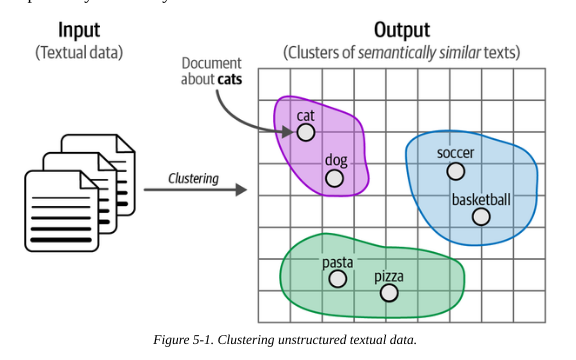

The clusters can the be used for applications such as outlier detection, speeding up labelling and finding mislabelled data.

It also has applications in **topic modelling**, where we assign a label or keywords to a cluster describing its constituents.


We apply this to an example data set of Arxiv articles. Let's load the Arxiv data we'll use for this:


In [1]:
from datasets import load_dataset 
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

Generating train split: 0 examples [00:00, ? examples/s]

## 1.2. Text clustering pipeline

There are many approaches to text clustering, including GNNs and centroid-based clustering. A common approach is:

1. Convert input documents to **embeddings**, using an *embedding model*
2. **Reduce the dimensionality** of those embeddings, using a *dimensionality reduction model*
3. **Group similar documents**, using a *cluster model*


### 1.2.1. The embedding model

We convert our text to embedding vectors using an embedding model. We should choose one that was trained to optimise *semantic similarity* (which most are). We can use the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) to help select a good model.

We can load a pre-trained model and create our embeddings.


In [5]:
from sentence_transformers import SentenceTransformer 

embedding_model = SentenceTransformer("thenlper/gte-small") 
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/Users/gurpreetjohl/miniconda3/envs/thellmbook/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

### 1.2.2. The dimensionality reduction model

High-dimensional data can suffer from the **curse of dimensionality**, making it difficult to find meaningful clusters.

We can use a dimensionality reduction model to *compress* (not remove) dimensions which makes the downstream clustering easier.

This is, by it’s nature, a lossy transformation. But we hope that *enough* of the information is retained to be useful.

Standard dimensionality reduction techniques include Principal Component Anaylsis (PCA) and Uniform Manifold Approximation (UMAP). We’ll use UMAP as it tends to handle nonlinear relationships better.

The following code reduces our embeddings from 384 -> 5 dimensions. We set `min_dist=0` as this allows embedded points to be arbitrarily close together, which results in tighter clusters, and `metric=‘cosine’` generally performs better than Euclidean methods for high-dimensional data.

In [7]:
from umap import UMAP

umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

/Users/gurpreetjohl/miniconda3/envs/thellmbook/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### 1.2.3. The cluster model

**Centroid-based** algorithms like K-Nearest Neighbours (KNN) are popular in other settings but require us to specify the number of clusters ahead of time (which we don’t know) and forces all data points to be part of a cluster (there can’t be unassigned points). This makes them less useful for our use case.

**Density-based** algorithms calculate the number of clusters freely and do not force all points into a cluster. We’ll use HDBSCAN for our case.

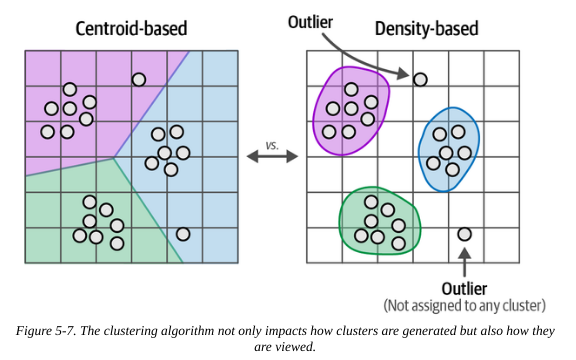

We can cluster the data with the following code. We can vary `min_cluster_size` to change the number of clusters produced.


In [8]:
from hdbscan import HDBSCAN 

hdbscan_model = HDBSCAN(min_cluster_size=50, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this war

We can inspect the clusters and plot the data in the reduced dimension space. Although helpful, it’s worth remembering that this is just an approximation of the real embeddings, some information is lost.


First, let's observe a selection of 3 documents from the first cluster to see if they seem similar:

In [9]:
import numpy as np 


# Print first three documents in cluster 0 
cluster = 0 
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



Now we can plot the data in the reduced embedding space:

In [10]:
import pandas as pd 


# Reduce 384-dimensional embeddings to two dimensions for easier visualization 
reduced_embeddings = UMAP(n_components=2, min_dist=0.0, metric="cosine", random_state=42 ).fit_transform(embeddings) 

df = pd.DataFrame(reduced_embeddings, columns=["x", "y"]) 
df["title"] = titles 
df["cluster"] = [str(c) for c in clusters] 

# Select outliers and non-outliers (clusters) 
to_plot = df.loc[df.cluster != "-1", :] 
outliers = df.loc[df.cluster == "-1", :]

/Users/gurpreetjohl/miniconda3/envs/thellmbook/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-7.562705826759339,
 10.960084271430969,
 -3.4470335602760316,
 18.276195919513704)

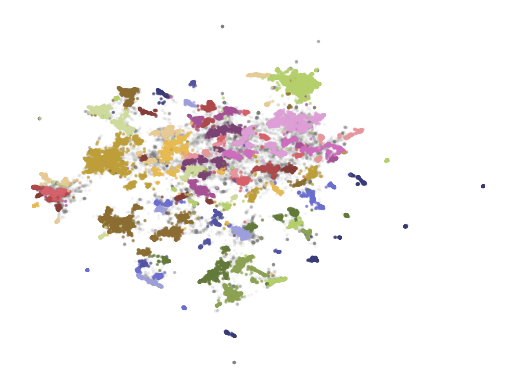

In [11]:
import matplotlib.pyplot as plt 


# Plot outliers and non-outliers separately 
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey") 
plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int), alpha=0.6, s=2, cmap="tab20b" ) 
plt.axis("off")

# 2. Topic Modelling

This is where we find themes or latent topics in a cluster; we want to find keywords or phrases that best represent the topic.

Classical approaches to topic modelling include latent Dirichlet allocation (LDA), where it’s assumed that each topic is characterised by a probability distribution of words in a corpus. These are generally *bag-of-words* approaches that do not account for context or meaning.

An LLM-based approach is the modular **BERTopic**.

## 2.1. BERTopic

The first step is to perform text clustering using the same 3 steps outlined in the previous section.

We then use a bag-of-words approach *per cluster* (instead of per document as would usually be the case) to model a distribution over words per class. This is the **CountVectorizer** step.

We similarly use a class-specific variant of term-frequency inverse document-frequency called **c-TF-IDF**, which puts more weight on the meaningful words of that cluster. 


We now have a generic **text clustering pipeline**:

```{mermaid}
flowchart LR

  A(Embeddings) --> B(Dimensionality Reduction) --> C(Clustering)
```

And a **topic modeling pipeline**:
```{mermaid}
flowchart LR

  D(Cluster Bag-of-Words) --> E(Keyword Selection)
```

Putting this all together with our choice of components:

```{mermaid}
flowchart LR

  A(SBERT) --> B(UMAP) --> C(HDBSCAN) --> D(CountVectorizer) --> E(c-TF-IDF)
```

The idea behind BERTopic is that these components are codular, so each can be swapped out like lego blocks. For example, if you prefer k-means clusters or PCA over UMAP, just swap it.

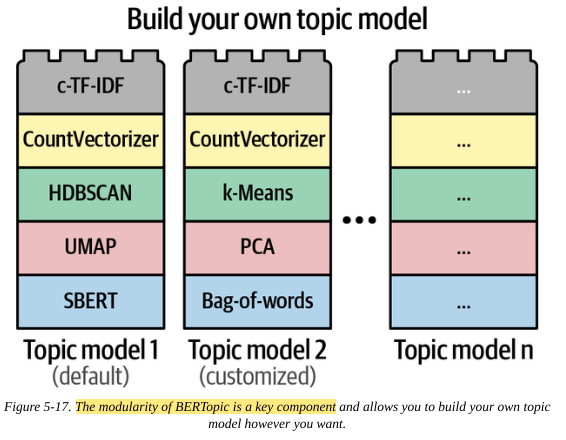

This modularity also means the same base model can be used and adapted for different tasks and use cases by adding/removing components downstream of the base model.

TODO: from p 212


# References

- Chapter 5 of Hands On LLMs
- [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard)